## Exploratory Data Analysis

Author: Sicong Zhao

**Table of Contents**

1. Distribution & Correlation of labels
2. By subject analysis
3. Emotion by `p_score` & `n_score`
4. PCA Analysis of Labels
5. Chord, emotion transformation
6. Would difference in `actual` and `ideal` measures relate to emotion regulation capability?
7. KMeans clustering (ha_p, p, la_p) (ha_n, n, la_n), see if we can detect something


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 200)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(10, 6)})
import copy
import datetime
import pdb
import plotly.express as px
from sklearn.cluster import KMeans
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()
import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

### 1.Load the Data & Pre-processing

In [2]:
exp = pd.read_csv('../../../data/processed/exp_steps_hr_sleep_survey.csv')
# Rmove outliers
exp = exp[exp['la_p']!=9]
# Generate 
exp['p_score'] = (exp['ha_p'] + exp['p'] + exp['la_p'])/3
exp['n_score'] = (exp['ha_n'] + exp['n'] + exp['la_n'])/3
# Label columns
label_cols = ['la_p', 'ha_p', 'p', 'p_score', 'ha', 'la_n', 'ha_n', 'n', 'n_score', 'la']
# Drop NA
exp = exp.dropna(subset=label_cols)
exp.head()

Unnamed: 0 subject  la_p  ha_p  ha_n  la_n   la    p    n   ha  ...  \
0           0    1047   2.0   3.0   1.0   1.0  2.0  4.0  1.0  1.0  ...   
1           1    1047   2.0   1.0   1.0   2.0  3.0  3.0  1.0  1.0  ...   
2           2    1047   3.0   3.0   1.0   1.0  3.0  5.0  1.0  1.0  ...   
3           3    1047   4.0   3.0   1.0   1.0  2.0  4.0  1.0  1.0  ...   
4           4    1047   4.0   1.0   1.0   2.0  4.0  2.0  1.0  1.0  ...   

  Marital_Status  Children Household_income Religion   Age  Medications  \
0        Married       3.0  $90,000-$99,999      NaN  43.0         None   
1        Married       3.0  $90,000-$99,999      NaN  43.0         None   
2        Married       3.0  $90,000-$99,999      NaN  43.0         None   
3        Married       3.0  $90,000-$99,999      NaN  43.0         None   
4        Married       3.0  $90,000-$99,999      NaN  43.0         None   

         BMI survey_hour   p_score   n_score  
0  27.328927        13.0  3.000000  1.000000  
1  27.328927         7.0  2.000000  1.333333  
2  27.328927        15.0  3.666667  1.000000  
3  27.328927        21.0  3.666667  1.000000  
4  27.328927         7.0  2.333333  1.333333  

[5 rows x 208 columns]

### 2.Distribution & Correlation of Labels

The correlation matrix looks reasonable.

Distribution wise, `ha_n` and `n` metrics are very right skewed.
* About 80% subjects reported `ha_n==1`
* About 76% subjects reported `n==1`
* About 68% subjects reported `ha_n==1 & n==1`

Since our analysis is trying to detect if the subject has negative emotion, could we create our label by using the following criteria:

* Normalize by subject.
* if `max(la_n, n, ha_n) >= max(la_p, p, ha_p)`, then `label == 1`, which represents the subject is unhappy. (This approach gives 26.6% unhappy label)

<string>:6: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.

/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning:


The label function will be deprecated in a future version. Use Tick.label1 instead.



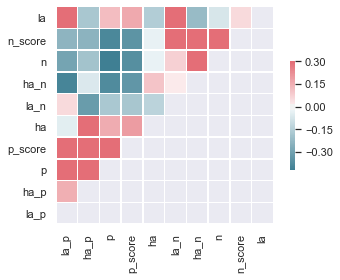

In [4]:
def correlation_heatmap(df):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(df, dtype=np.bool))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(df, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set_ylim(0,10)
corr = exp[label_cols].astype(int).corr()
correlation_heatmap(corr)

In [5]:
# corr_df = (corr > 0.29) & (corr < 1)
corr_df = corr.unstack().reset_index()
corr_df.columns = ['ele1','ele2','corr']

In [6]:
corr_df.sort_values(by='corr')

ele1     ele2      corr
27        p        n -0.418262
72        n        p -0.418262
60     ha_n     la_p -0.398199
6      la_p     ha_n -0.398199
82  n_score        p -0.385265
28        p  n_score -0.385265
62     ha_n        p -0.374300
26        p     ha_n -0.374300
73        n  p_score -0.362159
37  p_score        n -0.362159
83  n_score  p_score -0.345886
38  p_score  n_score -0.345886
36  p_score     ha_n -0.335978
63     ha_n  p_score -0.335978
51     la_n     ha_p -0.317883
15     ha_p     la_n -0.317883
70        n     la_p -0.290361
7      la_p        n -0.290361
18     ha_p  n_score -0.240843
81  n_score     ha_p -0.240843
80  n_score     la_p -0.236310
8      la_p  n_score -0.236310
69     ha_n       la -0.210650
96       la     ha_n -0.210650
17     ha_p        n -0.185987
71        n     ha_p -0.185987
35  p_score     la_n -0.179228
53     la_n  p_score -0.179228
19     ha_p       la -0.173569
91       la     ha_p -0.173569
52     la_n        p -0.170305
25        p     la_n -0.170305
49       ha       la -0.152822
94       la       ha -0.152822
54     la_n       ha -0.133264
45       ha     la_n -0.133264
79        n       la -0.067985
97       la        n -0.067985
61     ha_n     ha_p -0.061120
16     ha_p     ha_n -0.061120
4      la_p       ha -0.042536
40       ha     la_p -0.042536
84  n_score       ha -0.029115
48       ha  n_score -0.029115
74        n       ha -0.027421
47       ha        n -0.027421
65     ha_n     la_n  0.018007
56     la_n     ha_n  0.018007
98       la  n_score  0.054099
89  n_score       la  0.054099
50     la_n     la_p  0.055176
5      la_p     la_n  0.055176
75        n     la_n  0.077396
57     la_n        n  0.077396
46       ha     ha_n  0.103446
64     ha_n       ha  0.103446
29        p       la  0.117966
92       la        p  0.117966
1      la_p     ha_p  0.153479
10     ha_p     la_p  0.153479
24        p       ha  0.157182
42       ha        p  0.157182
93       la  p_score  0.164526
39  p_score       la  0.164526
34  p_score       ha  0.193141
43       ha  p_score  0.193141
95       la     la_n  0.325782
59     la_n       la  0.325782
41       ha     ha_p  0.364352
14     ha_p       ha  0.364352
90       la     la_p  0.453740
9      la_p       la  0.453740
21        p     ha_p  0.482292
12     ha_p        p  0.482292
76        n     ha_n  0.504721
67     ha_n        n  0.504721
20        p     la_p  0.510037
2      la_p        p  0.510037
58     la_n  n_score  0.548312
85  n_score     la_n  0.548312
68     ha_n  n_score  0.614507
86  n_score     ha_n  0.614507
78        n  n_score  0.651126
87  n_score        n  0.651126
13     ha_p  p_score  0.677379
31  p_score     ha_p  0.677379
30  p_score     la_p  0.688520
3      la_p  p_score  0.688520
23        p  p_score  0.817039
32  p_score        p  0.817039
0      la_p     la_p  1.000000
77        n        n  1.000000
66     ha_n     ha_n  1.000000
55     la_n     la_n  1.000000
44       ha       ha  1.000000
33  p_score  p_score  1.000000
22        p        p  1.000000
11     ha_p     ha_p  1.000000
88  n_score  n_score  1.000000
99       la       la  1.000000

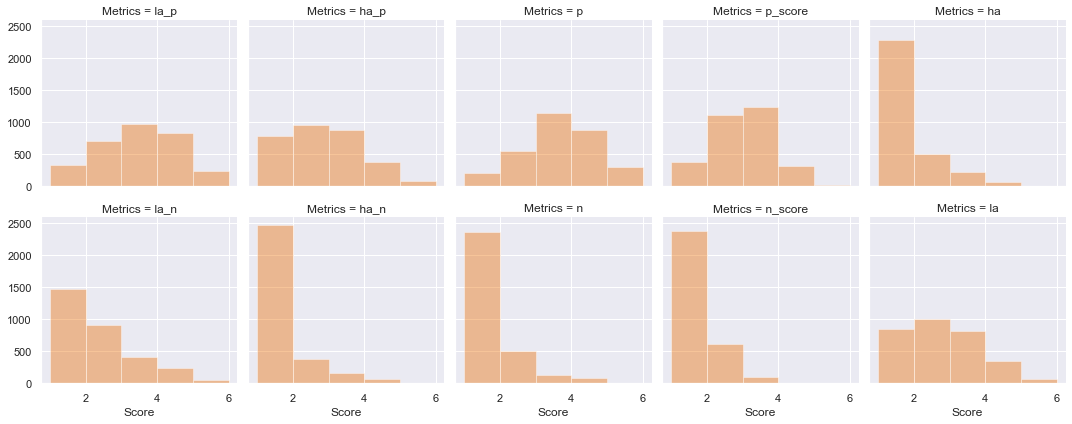

In [7]:
# Distribution of Each Labels
exp_label = exp[label_cols].stack().reset_index()
# Cleaning
del exp_label['level_0']
exp_label.columns = ['Metrics', 'Score']
label_dist = sns.FacetGrid(exp_label, col="Metrics", col_wrap=5)
label_dist = (label_dist.map(sns.distplot, "Score", hist=True, rug=False, kde = False, bins=range(1, 7, 1), color='#EA6C00'))

In [3]:
# Generate the label based on 2nd rule
exp['max_n'] = exp[['la_n','n','ha_n']].max(axis=1)
exp['max_p'] = exp[['la_p','p','ha_p']].max(axis=1)
exp['valence_bymax'] = exp['max_n'] >= exp['max_p']
sum(exp['valence_bymax'] == 1) / exp.shape[0]

0.2661473547549497

In [6]:
sum(exp['valence_bymax'] == 1)

820

In [9]:
exp[exp['valence_bymax'] == 1][['la_p','p','ha_p']].describe()

la_p           p        ha_p
count  820.000000  820.000000  820.000000
mean     2.219512    2.209756    1.662195
std      1.016643    0.912484    0.804010
min      1.000000    1.000000    1.000000
25%      1.000000    2.000000    1.000000
50%      2.000000    2.000000    1.000000
75%      3.000000    3.000000    2.000000
max      5.000000    5.000000    5.000000

In [10]:
exp[exp['valence_bymax'] == 0][['la_p','p','ha_p']].describe()

la_p            p         ha_p
count  2261.000000  2261.000000  2261.000000
mean      3.260062     3.509509     2.608138
std       1.013860     0.858339     1.046023
min       1.000000     1.000000     1.000000
25%       3.000000     3.000000     2.000000
50%       3.000000     3.000000     3.000000
75%       4.000000     4.000000     3.000000
max       5.000000     5.000000     5.000000

In [11]:
exp.groupby(['ha_n']).count()['subject']/exp.shape[0]

ha_n
1.0    0.799740
2.0    0.123337
3.0    0.053229
4.0    0.021097
5.0    0.002597
Name: subject, dtype: float64

In [12]:
exp.groupby(['n']).count()['subject']/exp.shape[0]

n
1.0    0.764687
2.0    0.162610
3.0    0.041870
4.0    0.027264
5.0    0.003570
Name: subject, dtype: float64

In [13]:
exp[(exp['n']==1)&(exp['ha_n']==1)].shape[0]/exp.shape[0]

0.6799740344044142

### 3.Relationships bewteen emotional states measures

All the following pattern looks reasonable. One thing worth mentioning is that `n & ha_n`, `ha & ha_n` highly concentrated.

In [14]:
def plot_scatter(col_a, col_b, ax):
    ax.title.set_text(col_b + ' & ' + col_a)
    exp_ = exp.loc[:,[col_a, col_b]]
    exp_.loc[:,'size'] = 1
    exp_plot = exp_.groupby([col_a, col_b]).count().reset_index()
    sns.scatterplot(x=col_a, y=col_b, data=exp_plot, hue="size", size="size", sizes=(20, 200), ax=ax)

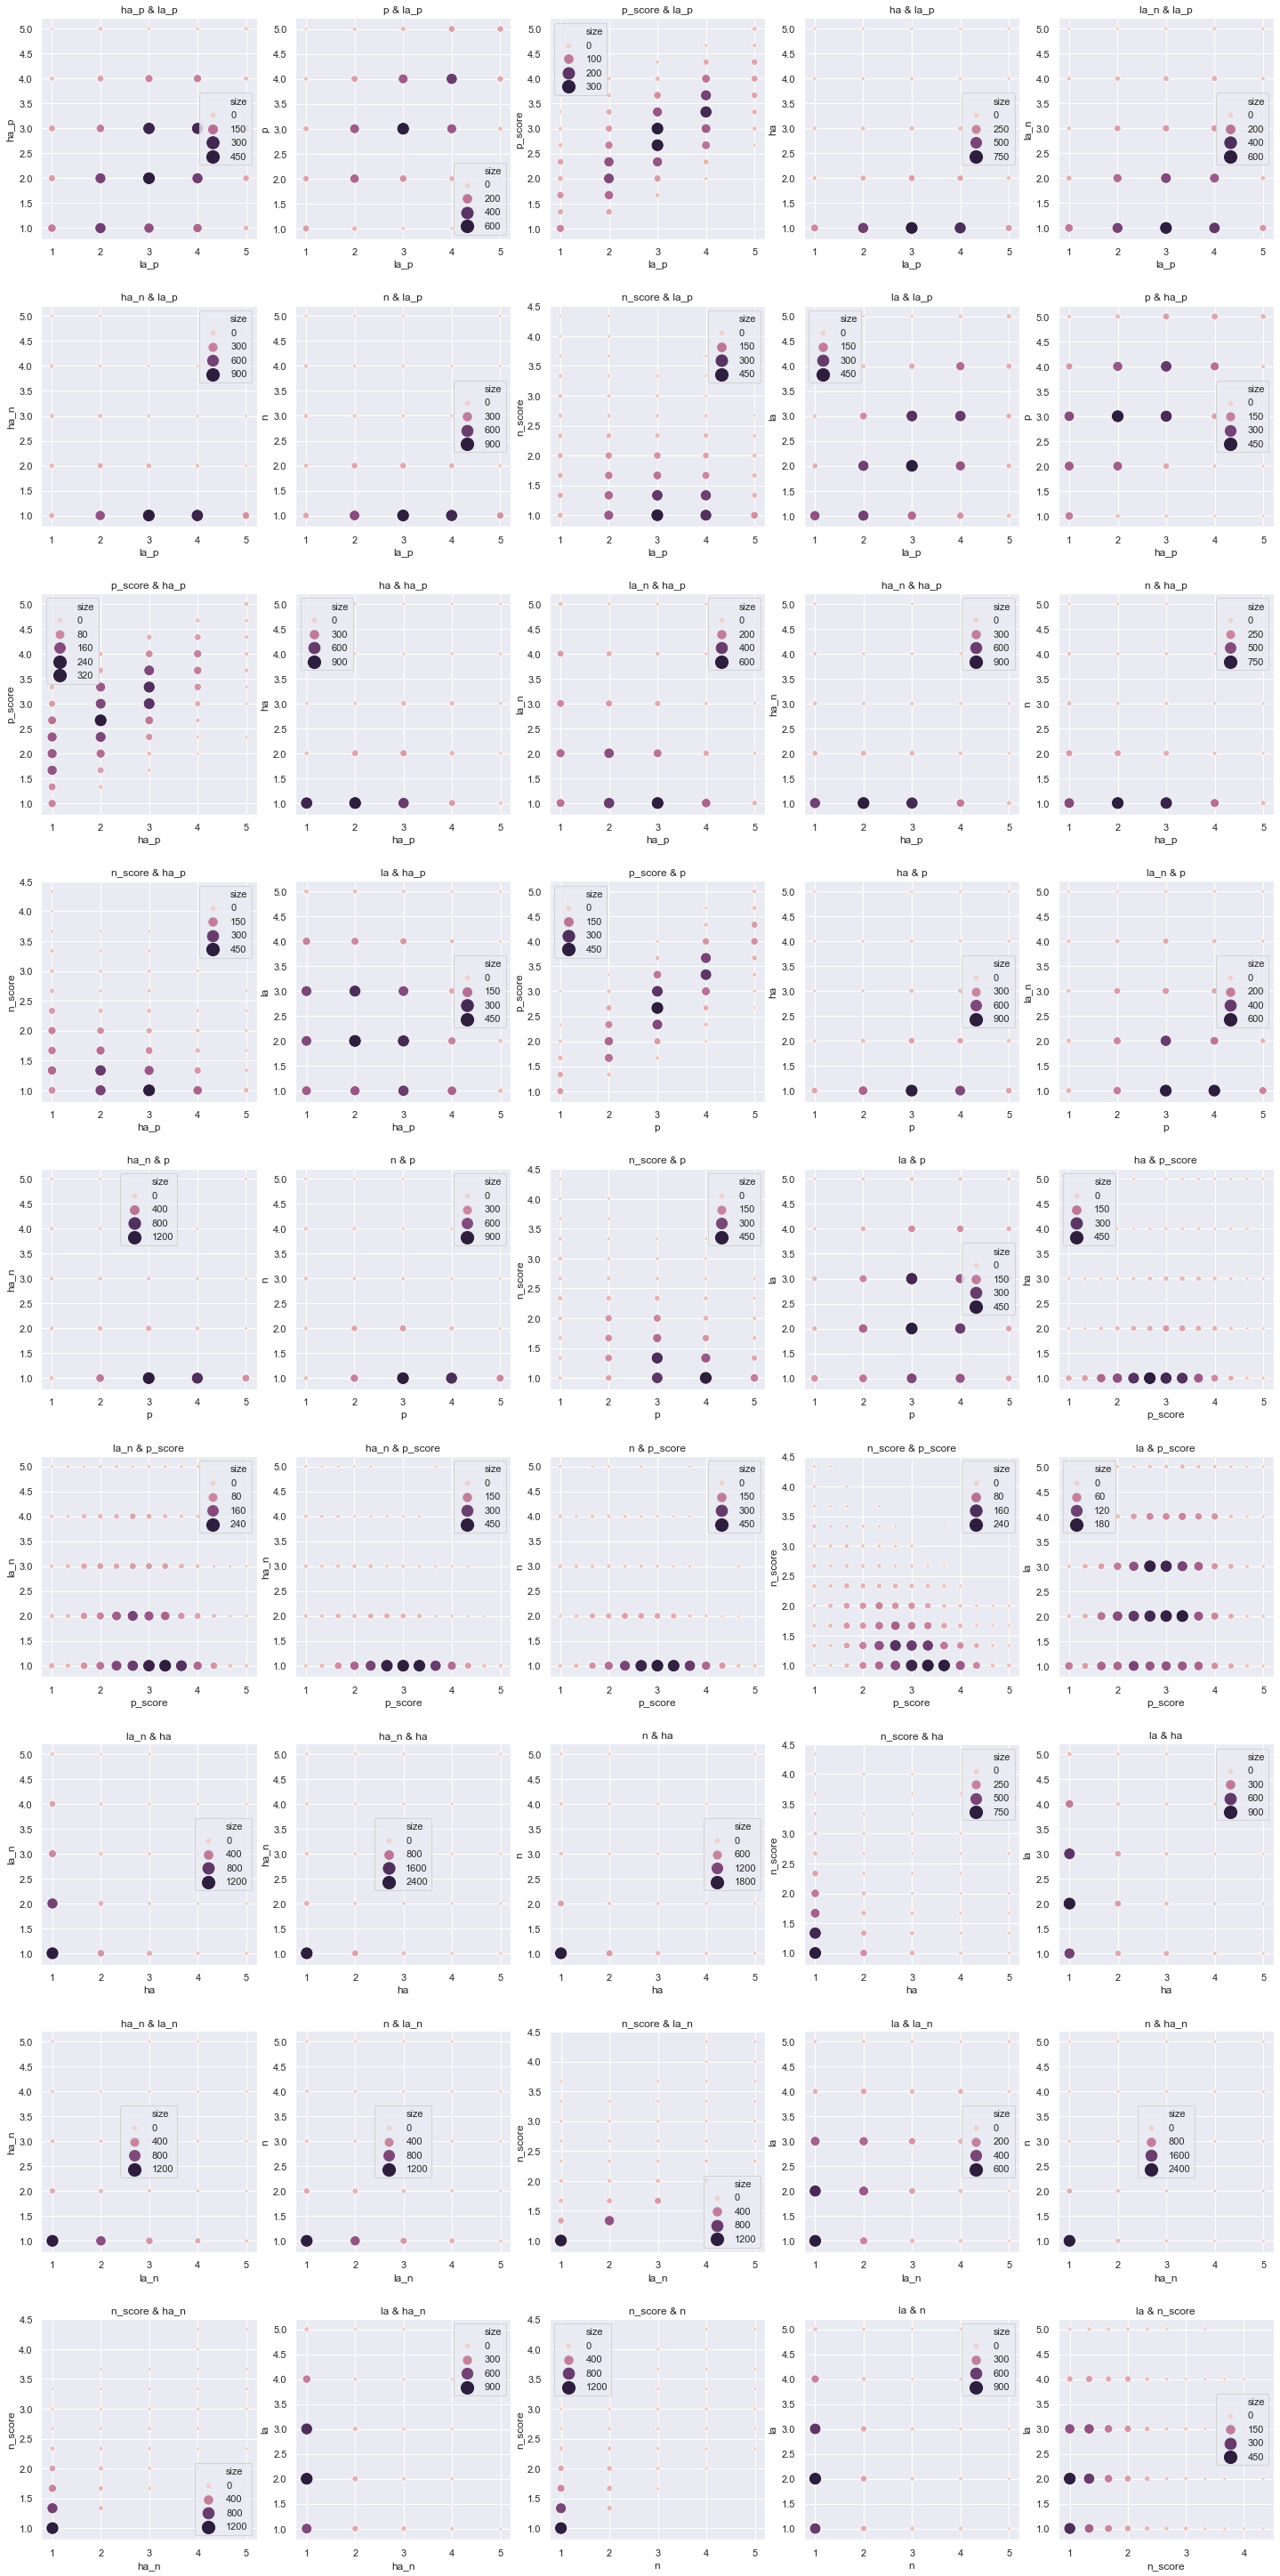

In [15]:
f, axs = plt.subplots(9, 5, figsize=(20,40))
f.tight_layout()
axs = axs.flatten()
count = 0
for i in range(10):
    for j in range(i+1, 10):
        plot_scatter(label_cols[i], label_cols[j], ax = axs[count])
        count+=1
plt.subplots_adjust(hspace=0.3)
plt.show()

### 4.By Subject Analysis

The subject level statistics indicates there is huge variance across subjects.

In [16]:
exp_by_subject = exp[['subject','p_score','n_score']].groupby('subject').agg(['min', 'max','mean','std','count'])

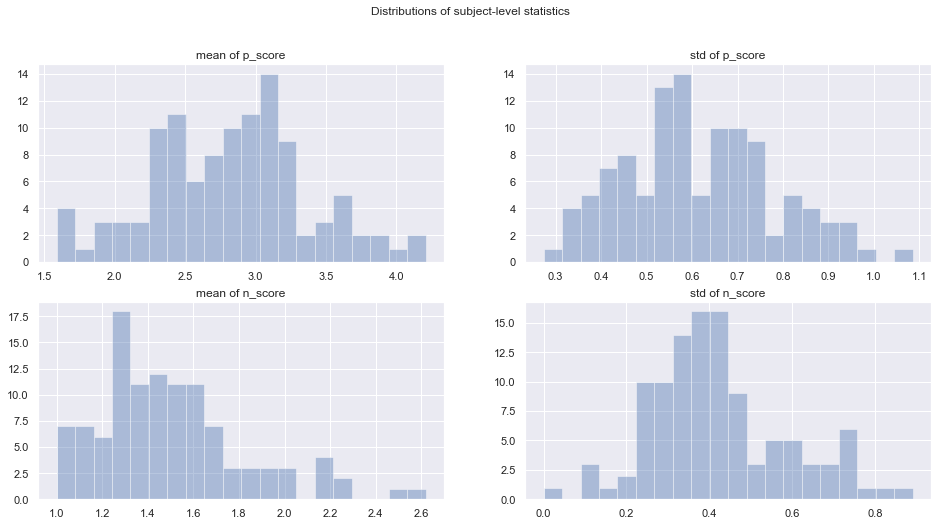

In [17]:
f, axs = plt.subplots(2, 2, figsize=(16,8))
f.suptitle('Distributions of subject-level statistics')
axs = axs.flatten()
sns.distplot(exp_by_subject['p_score']['mean'].values, bins=20, kde=False, ax=axs[0]);
sns.distplot(exp_by_subject['p_score']['std'].values, bins=20, kde=False, ax=axs[1]);
sns.distplot(exp_by_subject['n_score']['mean'].values, bins=20, kde=False, ax=axs[2]);
sns.distplot(exp_by_subject['n_score']['std'].values, bins=20, kde=False, ax=axs[3]);
axs[0].title.set_text('mean of p_score')
axs[1].title.set_text('std of p_score')
axs[2].title.set_text('mean of n_score')
axs[3].title.set_text('std of n_score')

### 5.Valence by Age

In [18]:
exp['Ages'] = None
for i in range(20,80,10):
    exp.loc[(exp['Age'] >= i)&(exp['Age'] < i+10), 'Ages'] = i

In [19]:
# Grouper of Age
count_by_age = pd.DataFrame(exp.groupby('Ages')['subject'].count())
count_by_age.columns = ['Count']
count_by_age = count_by_age.reset_index()
count_by_age

Ages  Count
0    20   1271
1    30    223
2    40    188
3    50   1047
4    60    209
5    70    118

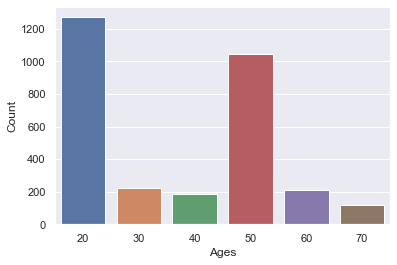

In [20]:
plt.figure(figsize=(6,4))
ax = sns.barplot(x="Ages", y="Count", data=count_by_age)

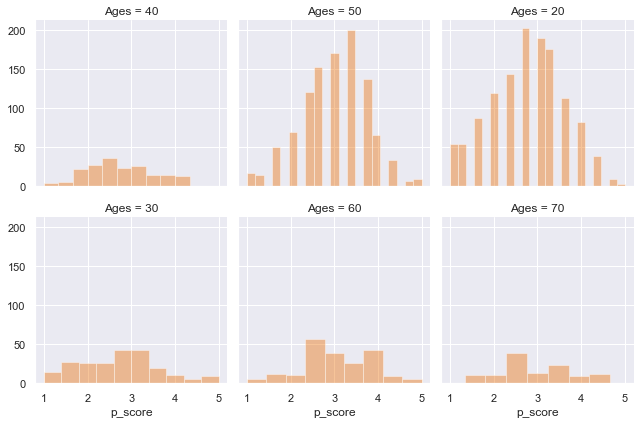

In [21]:
# Plot Positive Score by Age
pos_dist = sns.FacetGrid(exp[['Ages','p_score']], col="Ages", col_wrap=3)
pos_dist = (pos_dist.map(sns.distplot, "p_score", hist=True, rug=False, kde = False,  color='#EA6C00'))

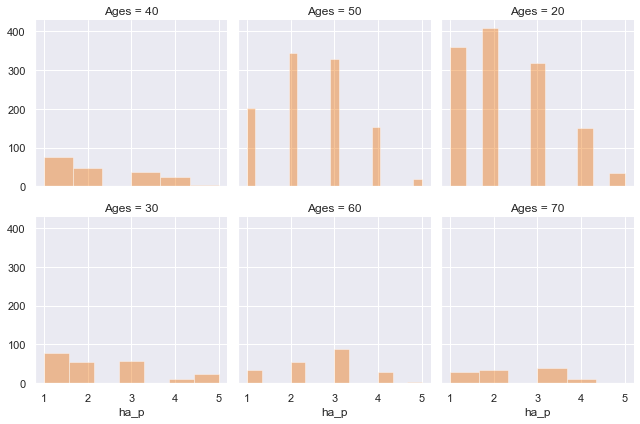

In [22]:
# Plot Positive Score by Age
pos_dist = sns.FacetGrid(exp[['Ages','ha_p']], col="Ages", col_wrap=3)
pos_dist = (pos_dist.map(sns.distplot, "ha_p", hist=True, rug=False, kde = False,  color='#EA6C00'))

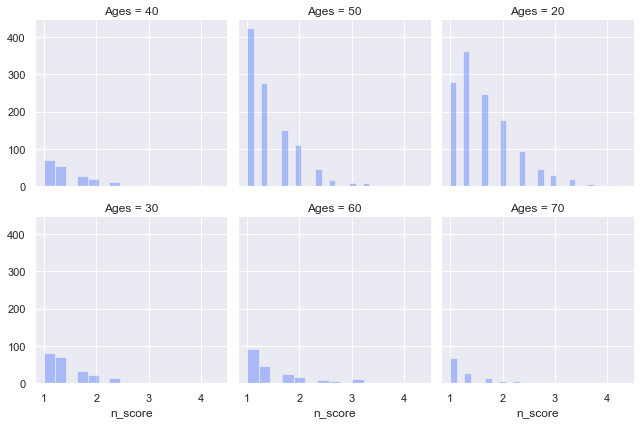

In [23]:
# Plot Negative Score by Age
neg_dist = sns.FacetGrid(exp[['Ages','n_score']], col="Ages", col_wrap=3)
neg_dist = (neg_dist.map(sns.distplot, "n_score", hist=True, rug=False, kde = False, color='#4671FB'))

### 5.PCA Analysis of Labels

3 principle components explains 72.8% of all the variance.

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
exp_label = exp[label_cols].dropna()
exp_label = exp_label[exp_label['la_p']!=9]
exp_label_norm = StandardScaler().fit_transform(exp_label)

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(exp_label_norm)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3'])

In [27]:
pca.explained_variance_ratio_.sum()

0.7277995433830536

### 6.Emotional States Transformation

**Analyze by population**

1. Transition probability at all time
2. Transition probability in day time
3. Transition probability at night

**(1) Transition probability of all time**

In [28]:
subjects = exp['subject'].unique()
exp_label = exp[['subject','start_survey'] + label_cols].dropna()

def gen_transition_matrix(df, metric):
    tm = [[0]*5 for _ in range(5)]

    # Calculation transition numbers
    for sub in subjects:
        ordered_survey = df.loc[df['subject'] == sub].sort_values(by=['start_survey'])
        ordered_survey[metric] = ordered_survey[metric].astype(int)
        if ordered_survey.shape[0] > 1:
            trans = ordered_survey[metric].values - 1
            for (i,j) in zip(trans[:-1],trans[1:]):
                tm[i][j] += 1
    tm_alltime = copy.deepcopy(tm)
    # Calculate transition probabilities
    for row in tm:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return tm, tm_alltime

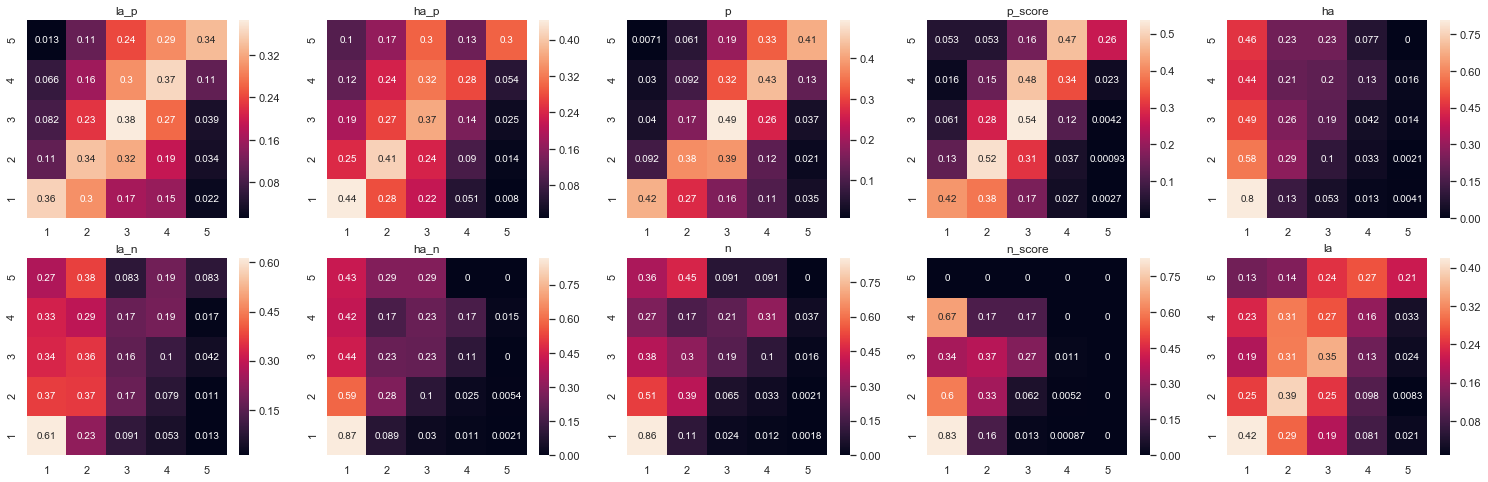

In [29]:
f, axs = plt.subplots(2, 5, figsize=(26,8))
axs = axs.flatten()

count = 0
for metric in label_cols:
    tm, _ = gen_transition_matrix(exp, metric)
    sns.heatmap(tm, annot=True, xticklabels=range(1,6), yticklabels=range(1,6), ax=axs[count])
    axs[count].title.set_text(metric)
    axs[count].set_ylim(0,5)
    count+=1

**(2) Transition probability of day time vs before/after sleep**

In [30]:
# Let's split the transitions from during daytime and cross days
exp['start_survey'] = pd.to_datetime(exp['start_survey'])
exp['date'] = exp['start_survey'].dt.date
exp_sorted = exp.sort_values(by=['subject','start_survey']).reset_index(drop=True)
# Shift
exp_sorted['prev_date'] = exp_sorted['date'].shift(1)
exp_sorted['prev_subject'] = exp_sorted['subject'].shift(1)
# Split data into day-time transition and cross-sleep transition
day_trans = exp_sorted[(exp_sorted['prev_date'] == exp_sorted['date']) & \
                            (exp_sorted['prev_subject'] == exp_sorted['subject'])]
night_trans = exp_sorted[(exp_sorted['prev_date'] + datetime.timedelta(days=1) == exp_sorted['date']) & \
                            (exp_sorted['prev_subject'] == exp_sorted['subject'])]

In [31]:
tm_var = np.subtract(tm_day, tm_night)**2
rmse = np.sqrt(np.mean(tm_var))
case_count = np.add(day_count, night_count)
case_dist = case_count/case_count.sum()
rmse_weighted = np.sqrt(np.sum(case_dist * tm_var))

NameError: name 'tm_day' is not defined

In [ ]:
rmse_weighted

In [ ]:
1.89083025e-02*0.11115214

In [ ]:
np.subtract(tm_day, tm_night)**2

In [ ]:
f, axs = plt.subplots(10, 4, figsize=(20,42))
axs = axs.flatten()

count = 0
for metric in label_cols:
    day = count * 4
    night = day + 1
    day_case = day + 2
    night_case = day + 3
    tm_day, day_count = gen_transition_matrix(day_trans, metric)
    tm_night, night_count = gen_transition_matrix(night_trans, metric)
    # Stats that indicate difference
    tm_var = np.subtract(tm_day, tm_night)**2
    rmse = np.sqrt(np.mean(tm_var))
    case_count = np.add(day_count, night_count)
    case_dist = case_count/case_count.sum()
    rmse_weighted = np.sqrt(np.sum(case_dist * tm_var))
    
    sns.heatmap(tm_day, annot=True, xticklabels=range(1,6), yticklabels=range(1,6), ax=axs[day])
    sns.heatmap(tm_night, annot=True, xticklabels=range(1,6), yticklabels=range(1,6), ax=axs[night])
    sns.heatmap(day_count, annot=True, xticklabels=range(1,6), yticklabels=range(1,6), ax=axs[day_case])
    sns.heatmap(night_count, annot=True, xticklabels=range(1,6), yticklabels=range(1,6), ax=axs[night_case])
    axs[day].title.set_text('Day: ' + metric + ' Diff: ' + str(rmse))
    axs[night].title.set_text('Night: ' + metric)
    axs[day_case].title.set_text('Day Count: ' + metric + 'W Diff: ' + str(rmse_weighted))
    axs[night_case].title.set_text('Night Count: ' + metric)
    for ele in [day, night, day_case, night_case]:
        axs[ele].set_ylim(0,5)

    count+=1

### 7.Emotional StatesTransformation by Age group

**Major Finding:** For la_n, people at 50s deals with it much better than people at 20s.
* With previous state to be `la_n=5`, the 50s have 78% chance to settle down to `la_n=1 or 2` in the next state, while the probability for the 20s is 61%.
* With previous state to be `la_n=4`, the 50s have 72% chance to settle down to `la_n=1 or 2` in the next state, while the probability for the 20s is 52%.

In [ ]:
for metric in label_cols:
    f, axs = plt.subplots(1, 6, figsize=(32,4))
    f.suptitle(metric + ' by Age')
    axs = axs.flatten('F')

    count = 0
    for age in range(20,80,10):
        exp_age = exp[exp['Ages'] == age]
        size = exp_age.shape[0]
        tm = gen_transition_matrix(exp_age, metric)
        sns.heatmap(tm, annot=True, xticklabels=range(1,6), yticklabels=range(1,6), ax=axs[count])
        axs[count].title.set_text(metric + ' at ' + str(age) + '(size: ' + str(size) + ')')
        axs[count].set_ylim(0,5)
        count+=1

In [ ]:
def mc(exp_label, metric):
    # Initialize the matrix
    tm = [[0]*5 for _ in range(5)]

    # Calculation transition numbers
    for sub in subjects:
        ordered_survey = exp_label.loc[exp_label['subject'] == sub].sort_values(by=['start_survey'])
        ordered_survey[metric] = ordered_survey[metric].astype(int)
        if ordered_survey.shape[0] > 1:
            trans = ordered_survey[metric].values - 1
            for (i,j) in zip(trans[:-1],trans[1:]):
                tm[i][j] += 1
    tm_alltime = copy.deepcopy(tm)

    # Calculate transition probabilities
    for row in tm:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    tp_alltime = copy.deepcopy(tm)
    plt.figure(figsize=(6,4))
#     sns.set(rc={'figure.figsize':(6, 4)})
    plt.title('Transition Matrix of: '+ metric+ ' for All Subjects')
    ax = sns.heatmap(tp_alltime, annot=True, xticklabels=range(1,6), yticklabels=range(1,6))
    ax.set_ylim(0,5)
    try:
        # Calculate stationary distributions
        evals, evecs = np.linalg.eig(np.array(tm).T)
#         pdb.set_trace()
        evec1 = evecs[:,np.isclose(evals, 1)][:,0]
        stationary = evec1 / evec1.sum()
        #eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
        stationary = stationary.real
        plt.figure(figsize=(8,3))
        stationary_plot(stationary, metric)
    except:
        print('Stationary Distribution of: '+ metric+' could not calculate')
    
def stationary_plot(stationary, metric):
    sns.set(rc={'figure.figsize':(6, 2)})
    plt.xticks(np.arange(5), ('1','2','3','4','5'))
    fig = plt.bar(np.arange(5), stationary, color=sns.color_palette("Blues",5))
    # plt.legend(fig, ['First','Second','Third'], loc = "upper left", title = "cat")
    plt.title('Stationary Distribution of: '+ metric+ ' for All Subjects')
    plt.show()

In [ ]:
mc(exp_label, 'ha_p')

From the heatmap above, it is weired to see the transition between 4, 5 are rare.
For subjects in state 1-3 their emotional states tend to stay the same, and gradually become a little happier/sad. 

However, things are different for happy subjects.
For subjects in state 4, they become sadder with probability of 0.66
For subjects in state 5, they become sadder with probability of 0.7

One possible explaination might be high arousal positive turned to positive or low arousal positive.

In [ ]:
for metric in label_cols+['valence_p','valence_n']:
    mc(exp_label, metric)

(2) Day time

In [ ]:
# Let's split the transitions from during daytime and cross days
exp['start_survey'] = pd.to_datetime(exp['start_survey'])
exp['date'] = exp['start_survey'].dt.date
exp_sorted = exp.sort_values(by=['subject','start_survey']).reset_index(drop=True)
# Shift
exp_sorted['prev_date'] = exp_sorted['date'].shift(1)
exp_sorted['prev_subject'] = exp_sorted['subject'].shift(1)
# Split data into day-time transition and cross-sleep transition
day_trans = exp_label_sorted[(exp_label_sorted['prev_date'] == exp_label_sorted['date']) & \
                            (exp_label_sorted['prev_subject'] == exp_label_sorted['subject'])]
night_trans = exp_label_sorted[(exp_label_sorted['prev_date'] + datetime.timedelta(days=1) == exp_label_sorted['date']) & \
                            (exp_label_sorted['prev_subject'] == exp_label_sorted['subject'])]

In [ ]:
day_trans = exp_label_sorted[(exp_label_sorted['prev_date'] == exp_label_sorted['date']) & \
                            (exp_label_sorted['prev_subject'] == exp_label_sorted['subject'])]
night_trans = exp_label_sorted[(exp_label_sorted['prev_date'] + datetime.timedelta(days=1) == exp_label_sorted['date']) & \
                            (exp_label_sorted['prev_subject'] == exp_label_sorted['subject'])]

In [ ]:
day_trans.shape

In [ ]:
night_trans.shape

In [ ]:
for metric in label_cols+['valence_p','valence_n']:
    mc(day_trans, metric)

In [ ]:
for metric in label_cols+['valence_p','valence_n']:
    mc(night_trans, metric)

In [ ]:
night_trans.describe()

(2) By Subject

In [ ]:
def stationary_by_subject(exp_label, metric):
    # Initialize the matrix
    tm = [[0]*5 for _ in range(5)]

    # Calculation transition numbers
    ordered_survey = exp_label.sort_values(by=['start_survey'])
    ordered_survey[metric] = ordered_survey[metric].astype(int)
    if ordered_survey.shape[0] > 1:
        trans = ordered_survey[metric].values - 1
        for (i,j) in zip(trans[:-1],trans[1:]):
            tm[i][j] += 1
        tm_alltime = copy.deepcopy(tm)
    else:
        return None
    
    # Calculate transition probabilities
    for row in tm:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    tp_alltime = copy.deepcopy(tm)
    try:
        # Calculate stationary distributions
        evals, evecs = np.linalg.eig(np.array(tm).T)
#         pdb.set_trace()
        evec1 = evecs[:,np.isclose(evals, 1)][:,0]
        stationary = evec1 / evec1.sum()
        stationary = stationary.real
        return stationary
    except:
        print('Stationary Distribution of: '+ metric+' could not calculate')
        return None

In [ ]:
# Calculate stationary distribution of positive valence and negative valence for each subject
exp_stationary_p = exp_label.groupby('subject').apply(lambda x: stationary_by_subject(x,'valence_p'))
exp_stationary_n = exp_label.groupby('subject').apply(lambda x: stationary_by_subject(x,'valence_n'))
# Formatting the result
exp_sta_p_df = pd.DataFrame(exp_stationary_p).reset_index()
exp_sta_n_df = pd.DataFrame(exp_stationary_n).reset_index()
exp_sta_p_df.columns = ['subject', 'p_state']
exp_sta_n_df.columns = ['subject', 'n_state']

In [ ]:
# Merge stationary distribution into design matrix
exp_sta_p = pd.merge(exp, exp_sta_p_df, how='left', left_on='subject', right_on='subject') 
exp_sta_pn = pd.merge(exp_sta_p, exp_sta_n_df, how='left', left_on='subject', right_on='subject') 
# Split each stationary distribution into five columns
exp_sta_pn[['p1_sta','p2_sta','p3_sta','p4_sta','p5_sta']] = pd.DataFrame(exp_sta_pn['p_state'].values.tolist(), index= exp_sta_pn.index)
exp_sta_pn[['n1_sta','n2_sta','n3_sta','n4_sta','n5_sta']] = pd.DataFrame(exp_sta_pn['n_state'].values.tolist(), index= exp_sta_pn.index)
# Delete old columns
del exp_sta_pn['n_state']
del exp_sta_pn['p_state']

The right approach for doing this is after aplitting data, add this feature. In this way, we can prevent information leakage.

## Part7 KMeans Analysis

In [ ]:
# Decide K

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [ ]:
X_pos = exp[['ha_p','p','la_p']].dropna().values
X_neg = exp[['ha_p','p','la_p']].dropna().values

wss_pos_res = calculate_WSS(X_pos, 100)
wss_neg_res = calculate_WSS(X_neg, 100)

In [ ]:
wss_pos = pd.DataFrame({'k-value': range(1,31), 'WSS': wss_pos_res[:30]})
plt.title('Within-Cluster-Sum of Squared over K for positive emotion')
sns.set(rc={'figure.figsize':(10, 6)})
sns.lineplot(x='k-value', y='WSS', data=wss_pos)

In [ ]:
wss_neg = pd.DataFrame({'k-value': range(1,31), 'WSS': wss_neg_res[:30]})
plt.title('Within-Cluster-Sum of Squared over K for negative emotion')
sns.set(rc={'figure.figsize':(10, 6)})
sns.lineplot(x='k-value', y='WSS', data=wss_neg)

In [ ]:
X_pos = exp[['ha_p','p','la_p']].dropna()
X_neg = exp[['ha_n','n','la_n']].dropna()


def cluster_plot(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X.values)
    X['clusters'] = kmeans.labels_
    x_col = X.columns.values
    fig = px.scatter_3d(X, x=x_col[0], y=x_col[1], z=x_col[2], color='clusters')
    fig.show()

cluster_plot(X_pos, 4)
cluster_plot(X_neg, 4)